In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

For text analysis, we will be using NLTK Library. From that we will be requiring stopword. So let’s download and import it using the below command.

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data = pd.read_csv('flipkart_data.csv')
data.head()


,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


In [4]:
# unique ratings
pd.unique(data['rating'])

array([5, 4, 1, 3, 2])

<Axes: xlabel='rating', ylabel='count'>

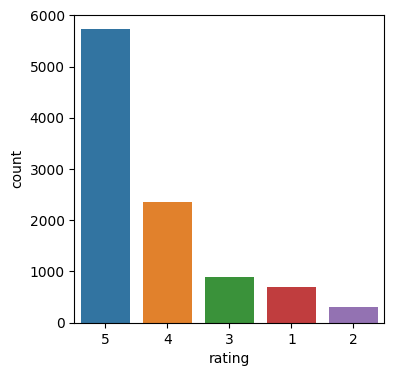

In [8]:
plt.figure(figsize=(4,4))
sns.countplot(data=data,
			x='rating',
			order=data.rating.value_counts().index)

To predict the Sentiment as positive(numerical value = 1) or negative(numerical value = 0), we need to change the rating column into an another column of 0s and 1s category. For that the condition will be like if the rating is less than or equal to 4, then it is negative(0) else positive(1)

In [9]:
# rating label(final)
pos_neg = []
for i in range(len(data['rating'])):
	if data['rating'][i] >= 5:
		pos_neg.append(1)
	else:
		pos_neg.append(0)

data['label'] = pos_neg

In [10]:
from tqdm import tqdm


def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		# Removing punctuations
		sentence = re.sub(r'[^\w\s]', '', sentence)

		# Converting lowercase and removing stopwords
		preprocessed_text.append(' '.join(token.lower()
										for token in nltk.word_tokenize(sentence)
										if token.lower() not in stopwords.words('english')))

	return preprocessed_text

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
preprocessed_review = preprocess_text(data['review'].values)
data['review'] = preprocessed_review

100%|██████████| 9976/9976 [00:13<00:00, 764.81it/s] 


In [14]:
data.head()

,review,rating,label
0,nice produt like design lot easy carry looked ...,5,1
1,awesome soundvery pretty see nd sound quality ...,5,1
2,awesome sound quality pros 78 hrs battery life...,4,0
3,think good product per quality also design qui...,5,1
4,awesome bass sound quality good bettary long l...,5,1


In [15]:
data["label"].value_counts()

1    5726
0    4250
Name: label, dtype: int64

To have the better picture of the importance of the words let’s create the Wordcloud of all the words with label = 1 i.e. positive

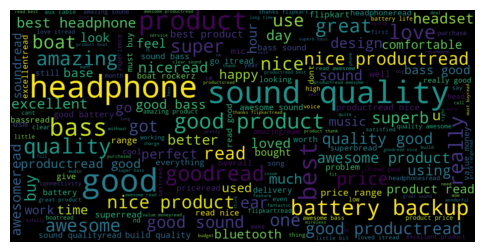

In [18]:
plt.figure(figsize=(6,6))
consolidated = ' '.join(
	word for word in data['review'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600, height=800,
					random_state=21, max_font_size=110)
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

Now it’s clear that the words like good, nice, product have high frequency in positive review, which satisfies our assumptions

**Converting text into Vectors**
TF-IDF calculates that how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set)

In [19]:
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(data['review'] ).toarray()

In [20]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['label'],
													test_size=0.33,
													stratify=data['label'],
													random_state = 42)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from  sklearn import svm

In [24]:
import numpy as np

In [25]:
#make variabel for save the result and to show it
classifier = ('Gradient Boosting','Random Forest','Decision Tree','K-Nearest Neighbor','SVM')
y_pos = np.arange(len(classifier))
score = []

In [26]:
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X, data['label'],cv=5)
score.append(scores.mean())
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 69.93%


In [28]:
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X, data['label'],cv=5)
score.append(scores.mean())
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 70.13%


In [29]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, data['label'],cv=5)
score.append(scores.mean())
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 66.17%


In [31]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, data['label'],cv=5)
score.append(scores.mean())
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 58.35%


In [32]:
clf  =  svm.LinearSVC(max_iter=5000)
scores = cross_val_score(clf, X, data['label'],cv=5)
score.append(scores.mean())
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 72.08%


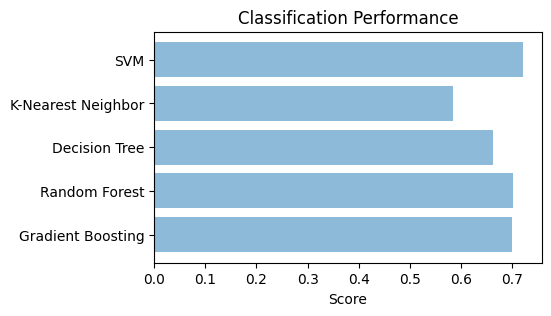

In [35]:
plt.figure(figsize=(5,3))
plt.barh(y_pos, score, align='center', alpha=0.5)
plt.yticks(y_pos, classifier)
plt.xlabel('Score')
plt.title('Classification Performance')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

#testing the model
pred = model.predict(X_test)
print(accuracy_score(y_test,pred))


0.6765866990586091


In [41]:
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train,y_train)

#testing the model
pred1 = model1.predict(X_test)
print(accuracy_score(y_test,pred1))

0.7215305192833282


In [42]:
model2 = svm.LinearSVC(max_iter=5000)
model2.fit(X_train,y_train)

#testing the model
pred2 = model2.predict(X_test)
print(accuracy_score(y_test,pred2))

0.7248709383540844
